<a href="https://colab.research.google.com/github/cmd-gunma-univ/DX-highschool/blob/main/SCD40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCD40を使ったCO2センサ

[マニュアル](https://akizukidenshi.com/goodsaffix/AE-SCD40-BO_20230124web.pdf)

[データシート](https://akizukidenshi.com/goodsaffix/SCD4x.pdf)

---
## 何ができるセンサか？

CO2の濃度，温度，湿度を測定できるセンサです。

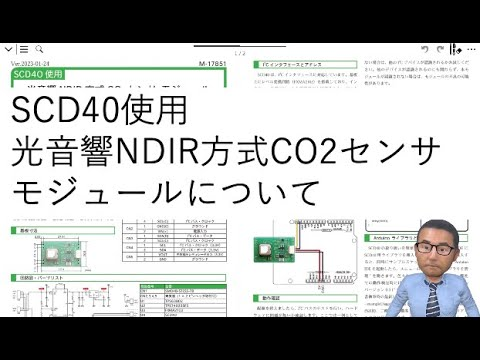

In [ ]:
#@title What's SCD40?
from IPython.display import YouTubeVideo
YouTubeVideo('dVd-iGOgjto', width=700, height=500)

---
## CO2の濃度測定原理 (光音響効果とは？)

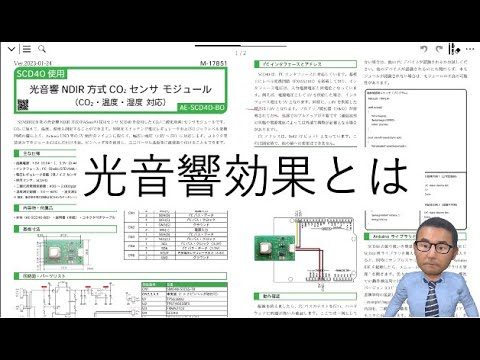

In [ ]:
#@title photoacoustic effect
from IPython.display import YouTubeVideo
YouTubeVideo('qdH00NlQuyI', width=700, height=500)

---
## 測定方法


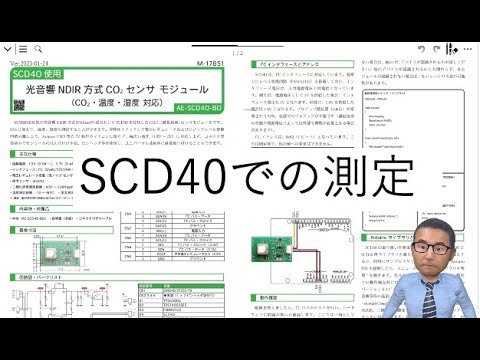

In [ ]:
#@title Measurement
from IPython.display import YouTubeVideo
YouTubeVideo('yFdxcDlyIZ4', width=700, height=500)

GND: GND (6)

VDD(3.3V): 3V3 (1)

SCL(クロック): GPIO2 (3)

SDA(データ): GPIO3 (5)

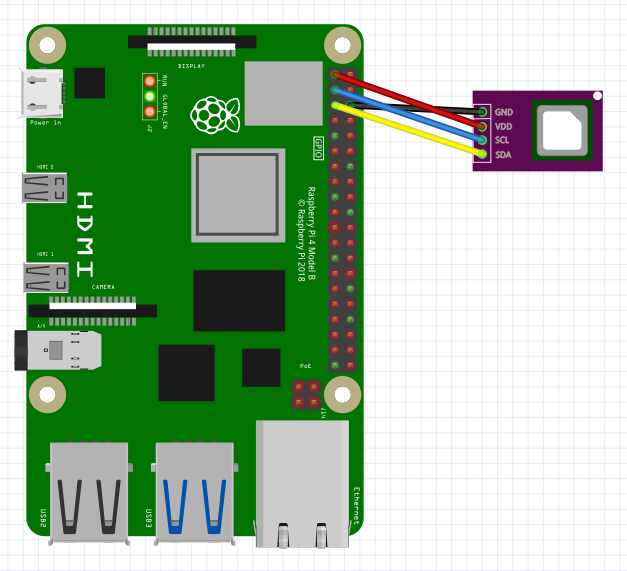

### i2C通信
クロック線(水色)とデータ線(黄色を使用)

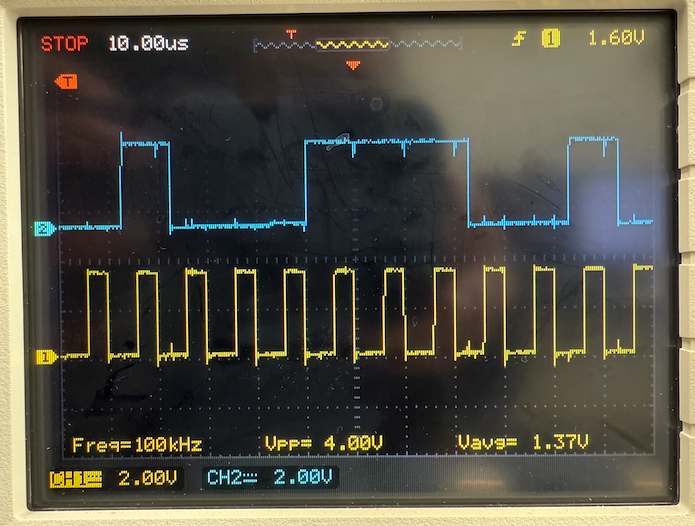

In [ ]:
import time
import board
import adafruit_scd4x
import ipywidgets as widgets
from IPython.display import display

# ✅ I2C 接続の初期化
i2c = board.I2C()
scd4x = adafruit_scd4x.SCD4X(i2c)
print("Serial number:", [hex(i) for i in scd4x.serial_number])

# ✅ 測定開始
scd4x.start_periodic_measurement()
print("Waiting for first measurement...")

# ✅ 停止フラグ
is_running = True

# ✅ 停止ボタンの作成
stop_button = widgets.Button(description="🛑 測定を停止する", button_style='danger')

# 停止ボタンが押されたときの処理
def on_stop_button_clicked(b):
    global is_running
    is_running = False  # 停止フラグをFalseに設定
    scd4x.stop_periodic_measurement()  # センサーの測定を停止
    print("✅ 測定を停止しました。")

# ボタンがクリックされたらon_stop_button_clickedを呼び出す
stop_button.on_click(on_stop_button_clicked)

# ✅ 停止ボタンの表示
display(stop_button)

# ✅ 測定ループ
while is_running:
    if scd4x.data_ready:
        print("CO2: %d ppm" % scd4x.CO2)
        print("Temperature: %0.1f *C" % scd4x.temperature)
        print("Humidity: %0.1f %%" % scd4x.relative_humidity)
        print("-" * 30)
    time.sleep(1)

In [ ]:
%matplotlib widget

import time
import board
import adafruit_scd4x
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display

# ✅ I2C 接続の初期化
i2c = board.I2C()
scd4x = adafruit_scd4x.SCD4X(i2c)
print("Serial number:", [hex(i) for i in scd4x.serial_number])

# ✅ 測定開始
scd4x.start_periodic_measurement()
print("Waiting for first measurement...")

# ✅ データ格納用
max_points = 60  # 過去1分間のデータを表示（1秒間隔 × 60）
timestamps = deque(maxlen=max_points)
co2_data = deque(maxlen=max_points)
temp_data = deque(maxlen=max_points)
humidity_data = deque(maxlen=max_points)

# ✅ プロットの初期化
plt.style.use('classic')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# 軸の設定
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0, max_points)  # X軸の範囲を固定
    ax.grid(True)               # グリッド表示

# ラインオブジェクトを初期化
line_co2, = ax1.plot([], [], label='CO₂ (ppm)', color='green')
line_temp, = ax2.plot([], [], label='Temperature (°C)', color='red')
line_humidity, = ax3.plot([], [], label='Humidity (%)', color='blue')

# ✅ 停止フラグ
is_running = True

# ✅ 停止ボタンの作成
stop_button = widgets.Button(description="🛑 測定を停止する", button_style='danger')

# 停止ボタンが押されたときの処理
def on_stop_button_clicked(b):
    global is_running
    is_running = False
    ani.event_source.stop()  # アニメーションの停止
    scd4x.stop_periodic_measurement()  # 測定の停止
    print("✅ 測定を停止しました。")

stop_button.on_click(on_stop_button_clicked)
display(stop_button)  # ボタンの表示

# ✅ ライブプロット関数
def update(frame):
    if is_running and scd4x.data_ready:
        current_time = time.strftime("%H:%M:%S")
        co2 = scd4x.CO2
        temp = scd4x.temperature
        humidity = scd4x.relative_humidity

        # データの格納
        timestamps.append(current_time)
        co2_data.append(co2)
        temp_data.append(temp)
        humidity_data.append(humidity)

        # データの更新
        x_data = list(range(len(timestamps)))
        line_co2.set_data(x_data, co2_data)
        line_temp.set_data(x_data, temp_data)
        line_humidity.set_data(x_data, humidity_data)

        # ✅ Y軸の自動スケーリング
        for ax in [ax1, ax2, ax3]:
            ax.relim()
            ax.autoscale_view()

        # ✅ データの出力
        print(f"Time: {current_time}")
        print(f"CO₂: {co2} ppm, Temp: {temp:.1f} °C, Humidity: {humidity:.1f}%")
        print("-" * 40)

    return line_co2, line_temp, line_humidity

# ✅ アニメーションの設定
ani = FuncAnimation(fig, update, interval=1000, blit=False, cache_frame_data=False)

# グラフ表示
plt.tight_layout()
plt.show()